# Model 1: Text Classification with Logistic Regression using `sklearn`

Our goal is to build a ML model that uses the features to predict the label:
- **Feature:** A bag of words (questions from Quora users; `question_text` in the `train.csv` and `test.csv` datasets)
- **Label (Binary):** Insincere (TRUE or FALSE; `target` in the `train.csv` dataset)

## Step 1: Import libraries

Ensure that all the required libraries have been installed by running `pip install <LIBRARY>` in the terminal.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score
from sklearn.model_selection import cross_val_score

## Step 2: Load data

In [ ]:
# loading train and test datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# printing the first 5 rows of train dataset
train.head()

# printing the first 5 rows of test dataset
test.head()

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


## Step 3: Perform Text Vectorization

Text Vectorization is the process of converting text into numerical representation.

For our use case, we are converting `question_text` to a matrix of TF-IDF (which measures the frequency of a word in a text against its overall frequency in the corpus) features.

In [ ]:
text_vectorizer = TfidfVectorizer(max_features=2000)

train_vector = text_vectorizer.fit_transform(train["question_text"])
test_vector = text_vectorizer.transform(test["question_text"])

## Step 4: Splitting X and Y into training and validation sets

As Quora provided the train and test datasets separately, there is no need to split X and Y into training and testing sets. Instead, X and Y are split into training and validation sets.

The `stratify` argument is used for Y to be split into training and validation sets as they are in the original dataset.

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(
    train_vector,
    train["target"],
    test_size=0.2,
    stratify=train["target"],
    random_state=42)

## Step 5: Choose classifiers

The three chosen classifers are the following models:

    - Logistic Regression
    - SVM with linear kernel
    - Bernoulli

In [ ]:
# setting up the Logistic Regression model
log_model = LogisticRegression(solver='lbfgs', max_iter=3000)

# setting up the SVM model with linear kernel
svm_model = SVC(kernel='rbf')

# setting up the Bernoulli model
bernoulli_model = BernoulliNB()

## Step 6: Train the chosen classifiers and calculate metrics

The metrics that are used to analyze the performance are:

    - F-1 Score
    - ROC AUC Score

Along with these two scores, the confusion matrix is displayed with a _heatmap_.

[Text Classification using LogisticRegression(max_iter=3000)]
   1) F1 score: 0.47
      - Mean F1 score for train set in cross validation: 0.47
      - Standard deviation of F1 score for train set in cross validation: 0.00
      - Mean F1 score for test set in cross validation: 0.47
      - Standard deviation of F1 score for test set in cross validation: 0.01
   2) ROC AUC score: 0.93
      - Mean ROC AUC score for train set in cross validation: 0.93
      - Standard deviation of ROC AUC score for train set in cross validation: 0.00
      - Mean ROC AUC score for test set in cross validation: 0.92
      - Standard deviation of ROC AUC score for test set in cross validation: 0.00
   3) ROC Curve


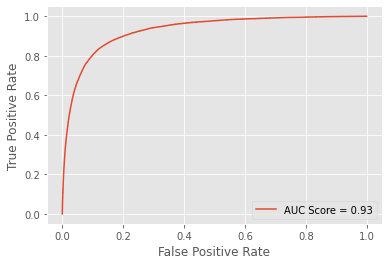

   4) Confusion Matrix


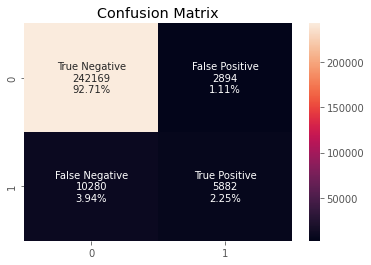

In [ ]:
# scaling X
scaler_X = StandardScaler(with_mean=False)
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

# creating a method that train the model, predict using the model, and calculate metrics
def model_and_predict(model, X_train_scaled, y_train, X_val_scaled, y_val):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    y_pred_auc = model.predict_proba(X_val_scaled) # auc score uses predict_proba() under the hood, not predict()

    f1 = f1_score(y_val, y_pred)
    f1_train_cv = cross_val_score(model, X_train_scaled, y_train, scoring="f1", cv=10)
    mean_f1_train_cv = f1_train_cv.mean()
    std_f1_train_cv = f1_train_cv.std()
    f1_test_cv = cross_val_score(model, X_val_scaled, y_val, scoring="f1", cv=10)
    mean_f1_val_cv = f1_test_cv.mean()
    std_f1_val_cv = f1_test_cv.std()
    fpr, tpr, _ = roc_curve(y_val, y_pred_auc[:, 1])
    auc = roc_auc_score(y_val, y_pred_auc[:, 1])
    auc_train_cv = cross_val_score(model, X_train_scaled, y_train, scoring="roc_auc", cv=10)
    mean_auc_train_cv = auc_train_cv.mean()
    std_auc_train_cv = auc_train_cv.std()
    auc_val_cv = cross_val_score(model, X_val_scaled, y_val, scoring="roc_auc", cv=10)
    mean_auc_val_cv = auc_val_cv.mean()
    std_auc_val_cv = auc_val_cv.std()
    conf_matrix = confusion_matrix(y_val, y_pred)

    print("[Text Classification using %s]"%(model))
    print("   1) F1 score: %.2f"%(f1))
    print("      - Mean F1 score for train set in cross validation: %.2f"%(mean_f1_train_cv))
    print("      - Standard deviation of F1 score for train set in cross validation: %.2f"%(std_f1_train_cv))
    print("      - Mean F1 score for test set in cross validation: %.2f"%(mean_f1_val_cv))
    print("      - Standard deviation of F1 score for test set in cross validation: %.2f"%(std_f1_val_cv))
    print("   2) ROC AUC score: %.2f"%(auc))
    print("      - Mean ROC AUC score for train set in cross validation: %.2f"%(mean_auc_train_cv))
    print("      - Standard deviation of ROC AUC score for train set in cross validation: %.2f"%(std_auc_train_cv))
    print("      - Mean ROC AUC score for test set in cross validation: %.2f"%(mean_auc_val_cv))
    print("      - Standard deviation of ROC AUC score for test set in cross validation: %.2f"%(std_auc_val_cv))
    print("   3) ROC Curve")
    plt.plot(fpr, tpr, label='AUC Score = %.2f'%(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    # plt.savefig('C:/Users/Soohyun/Desktop/UW MGTE \'23/YEAR 4/4B/MSCI 546/Term Project/quora-insincere-questions/1_baseline_classification/images/roc_curve_log_reg.png')
    # plt.close()
    print("   4) Confusion Matrix")
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_matrix, annot=labels, fmt='')
    plt.title("Confusion Matrix")
    plt.show()
    # plt.savefig('C:/Users/Soohyun/Desktop/UW MGTE \'23/YEAR 4/4B/MSCI 546/Term Project/quora-insincere-questions/1_baseline_classification/images/confusion_matrix_log_reg.png')
    # plt.close()

# calling method above for every model but commenting it out to reduce computational time
# baseline_models = [log_model, svm_model, bernoulli_model]

# calling method above for logistic regression model only
baseline_models = [log_model]
for model in baseline_models:
    model_and_predict(model, X_train_scaled, y_train, X_val_scaled, y_val)

## Step 7: Predict test dataset using the "best" classifier

Now that the performance of each classifier has been observed, the test dataset is ready to be predicted using the classifier with the "best" metrics.

In [ ]:
result = np.array(np.mean(log_model.predict_proba(test_vector)[:, 1], axis=0) > 0.5, dtype=int)
result_df = pd.DataFrame({"qid": test["qid"], "prediction": result})
result_df.to_csv("result.csv", index=False)